In [2]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import compute_dRSA, spearman, get_lagplot

In [3]:
from neural_utils.utils import load_monkey_data, load_stimuli_models, min_max_normalization, extract_fixations_onset, get_start_end_chunk
monkey_name = "venus"
month = 'sep'
day = 20
resolution_Hz = 100
npx = True
imec_n = 0
normalization = "min_max"
model_name = "dgIIE"
day = str(day)
neural_data, gaze_data = load_monkey_data(paths, monkey_name, day, month, resolution_Hz, npx=npx, imec_n=imec_n)
# normalizes them 
if normalization == "min_max":
    n_norm = min_max_normalization(neural_data)
# ADD zscore? robust?
elif normalization == None:
    n_norm = delete_empty_keys(neural_data)

# loads and upsamples the model 
all_models = load_stimuli_models(paths, model_name, n_norm.keys(), resolution_Hz)

# extract_fixation_responses(n_norm, gaze_data, all_models, n_timepts_bef, n_timepts_aft, foreperiod_len_timepts=30)

## Different ways to sample:
- continous, i.e. 1 pseudo-trial per stimulus (decide how to treat repetitions)
- fixation-locked
    - all fixations in a trial, then average across reps of the same trial, then average across stimuli
    - one fixation per trial
        - random fixation, then repeat the analyses for different fixations sets
        - first fixation
        - fixation at a specific moment in time
    - all face fixations vs all non-face fixations

## Random trials

In [5]:
n, g, m = random_trials_per_rep(n_norm, gaze_data, all_models, 200)

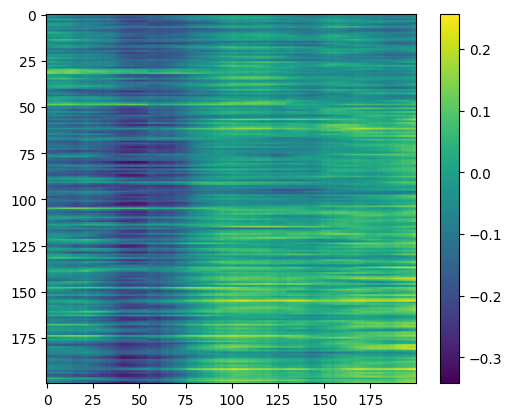

In [6]:
dRSA = compute_dRSA(g[:,:,:], m[:,:,:], metric_RDM='correlation',metric_RDM_model='correlation', metric_dRSA=spearman)
plt.imshow(dRSA)
plt.colorbar()

18:20:27 - The number of datapoints used to compute extreme offsets is < than 10


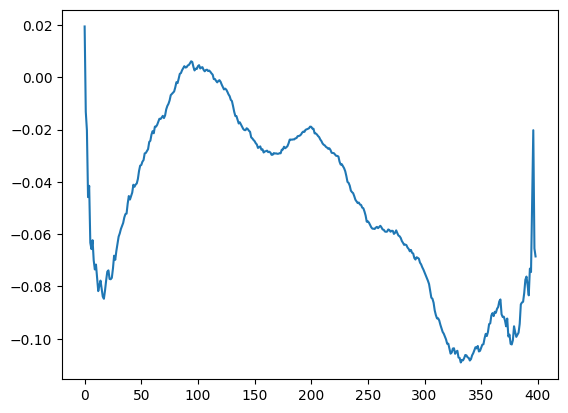

In [7]:
plt.plot(get_lagplot(dRSA, max_lag=199))

## Fixation-locked

### All fixations in all the repetitions

In [ ]:
def extract_all_fixation_responses(n_norm, gaze_data, all_models, n_timepts_bef, n_timepts_aft, foreperiod_len_timepts=30):
    all_neural_fix = []
    all_gaze_fix = []
    all_model_fix = []
    for fn in n_norm.keys()[:2]: # loops through all the stimuli
        for i in range(n_norm[fn].shape[2]): # loops thourgh all the repetitions
            current_neural = n_norm[fn][:,:,i]
            current_gaze = gaze_data[fn][:,:,i]
            current_model = all_models[fn]
            fixations_vector = current_gaze[2,:] 
            fixation_onsets = extract_fixations_onset(fixations_vector, foreperiod_len_timepts=foreperiod_len_timepts)
            for onset in fixation_onsets:
                start, end = get_start_end_chunk(onset, foreperiod_len_timepts, n_timepts_bef, n_timepts_aft)
                if not (start < 0 or end > current_neural.shape[1]): # if it's not too close to the beginning or end
                    if not (onset - n_timepts_bef < 0): # checks that the onset doesn't start before the stimulus onset (because we don't have the model for that)
                        neural_fix = current_neural[:,start:end] # indexing period around fixation
                        gaze_fix = current_gaze[:2, start:end] 
                        model_fix = current_model[:, onset-n_timepts_bef:onset+n_timepts_aft]
                        all_neural_fix.append(neural_fix)
                        all_gaze_fix.append(gaze_fix)
                        all_model_fix.append(model_fix)
    all_neural_fix = np.stack(all_neural_fix, axis=-1)
    all_gaze_fix = np.stack(all_gaze_fix, axis=-1)
    all_model_fix = np.stack(all_model_fix, axis=-1)    
    return all_neural_fix, all_gaze_fix, all_model_fix


### All fixations in a single stimulus (also multiple repetitions)

18:23:58 - The number of datapoints used to compute extreme offsets is < than 10
18:23:58 - The number of datapoints used to compute extreme offsets is < than 10
18:23:58 - The number of datapoints used to compute extreme offsets is < than 10
18:23:59 - The number of datapoints used to compute extreme offsets is < than 10
18:24:02 - The number of datapoints used to compute extreme offsets is < than 10
18:24:03 - The number of datapoints used to compute extreme offsets is < than 10
18:24:03 - The number of datapoints used to compute extreme offsets is < than 10
18:24:04 - The number of datapoints used to compute extreme offsets is < than 10
18:24:06 - The number of datapoints used to compute extreme offsets is < than 10
18:24:06 - The number of datapoints used to compute extreme offsets is < than 10


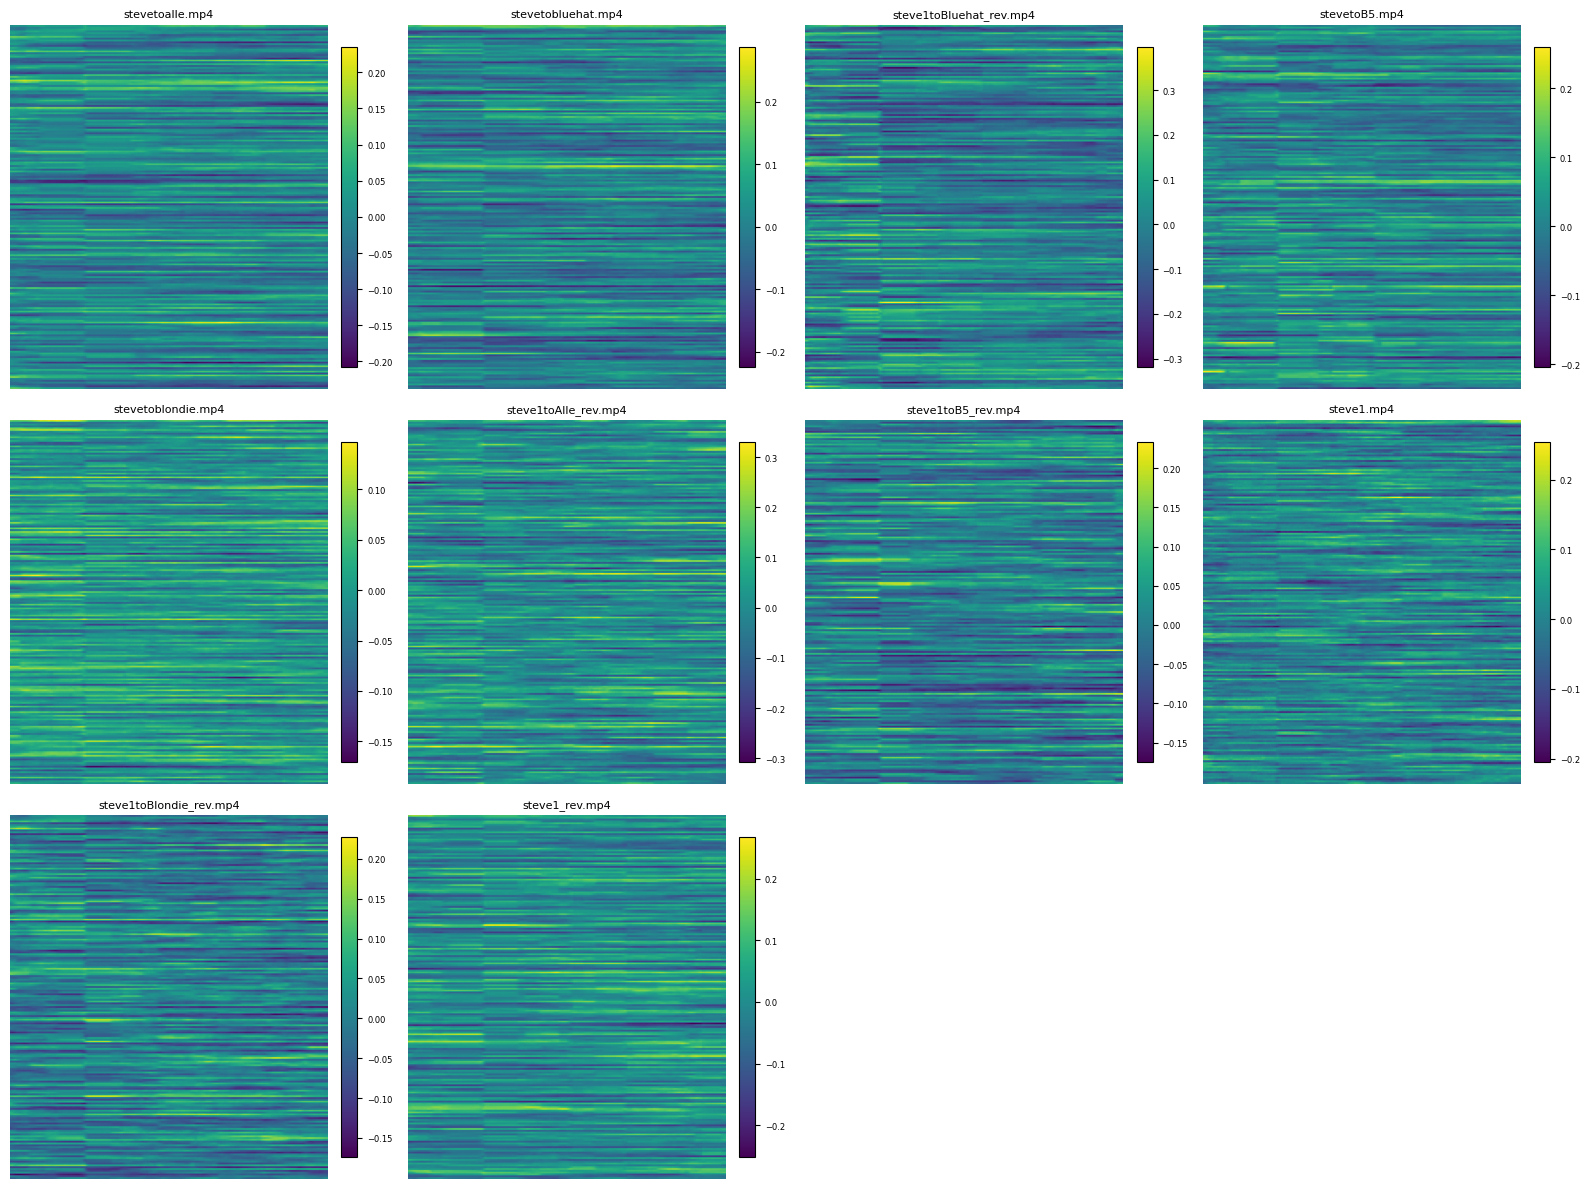

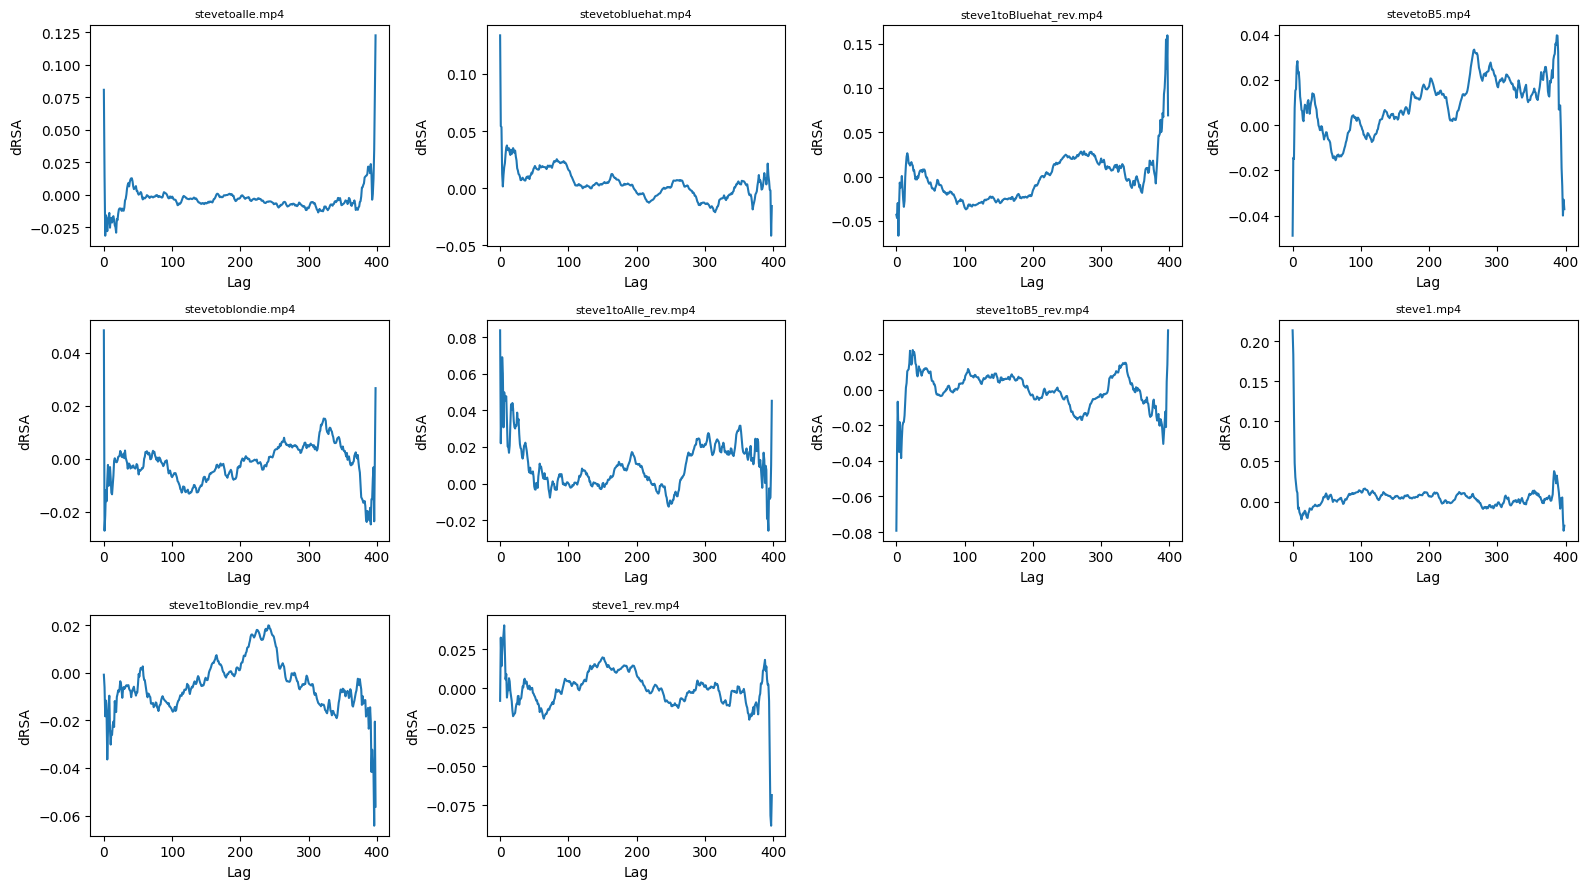

In [13]:
import matplotlib.pyplot as plt
import math

fns = list(n_norm.keys())
n_fns = len(fns)
lagplots = []

# -----------------------------
# FIGURE 1 — HEATMAPS
# -----------------------------

n_cols = math.ceil(math.sqrt(n_fns))
n_rows = math.ceil(n_fns / n_cols)

fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes1 = axes1.flatten()

for ax, fn in zip(axes1, fns):
    # compute fixation responses
    neural_data_fix, gaze_data_fix, model_data_fix = extract_fixation_responses_sing_trial(
        n_norm, gaze_data, all_models, fn, 50, 150
    )
    
    if neural_data_fix.shape[2] > 1:
        # compute dRSA
        dRSA = compute_dRSA(
            neural_data_fix[270:290, :, :],
            gaze_data_fix[:, :, :],
            metric_RDM='euclidean',
            metric_RDM_model='euclidean',
            metric_dRSA='correlation'
        )
        lagplots.append(get_lagplott(dRSA, max_lag=199, summary_stat='mean'))

        # plot heatmap
        im = ax.imshow(dRSA, aspect='auto', cmap='viridis')
        ax.set_title(fn, fontsize=8)
        ax.axis('off')

        # colorbar
        cbar = fig1.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=6)
    else:
        lagplots.append(np.array([]))

# turn off unused axes
for ax in axes1[len(fns):]:
    ax.axis('off')

fig1.tight_layout()


# -----------------------------
# FIGURE 2 — LAG PLOTS
# -----------------------------

fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes2 = axes2.flatten()

for ax, fn, lag_vals in zip(axes2, fns, lagplots):
    
    ax.plot(lag_vals)
    ax.set_title(fn, fontsize=8)
    ax.set_xlabel('Lag')
    ax.set_ylabel('dRSA')

# turn off unused axes
for ax in axes2[len(lagplots):]:
    ax.axis('off')

fig2.tight_layout()

# -----------------------------
# SHOW BOTH FIGURES
# -----------------------------
plt.show()

In [14]:
def concatenate_all_trials_cut_foreperiod(neural_data, foreperiod_len):
    all_trials = []
    for key in neural_data.keys():
        trial = neural_data[key][:, foreperiod_len:, :]
        if trial.shape != (0,):
            trial_flat = trial.reshape(trial.shape[0], -1, order="F")
            all_trials.append(trial_flat)
    tot_data = np.concatenate(all_trials, axis=1)
    return tot_data


In [243]:
neural_concat = concatenate_all_trials_cut_foreperiod(neural_data, 30)
gaze_concat = concatenate_all_trials_cut_foreperiod(gaze_data, 30)


In [244]:
n_trials = 300
len_trial = 400
rand_trials = np.random.randint(neural_concat.shape[1] - len_trial -1, size=n_trials)
tot_neural_trials = []
tot_gaze_trials = []
for trial_onset in rand_trials:
    tot_neural_trials.append(neural_concat[:,trial_onset:trial_onset+len_trial])
    tot_gaze_trials.append(gaze_concat[:,trial_onset:trial_onset+len_trial])
tot_neural_trials = np.stack(tot_neural_trials, axis=-1)
tot_gaze_trials = np.stack(tot_gaze_trials, axis=-1)